In [ ]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
import random
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#import tensorflow as tf

from sklearn.metrics import mean_absolute_error #


Github link:
https://github.com/ChZPan/stock-market-prediction-RNN/tree/0470d74adc82c42eed8009d35b5441782eac7806

In [ ]:
# Data preperation 
class StockIndexDataset:
    def __init__(self,
                 dataset_files,
                 index_name="SH300IF",
                 batch_size=32,
                 time_steps=12,
                 forecast_steps=0,
                 val_ratio=0.2,
                 test_ratio=0.2,
                 test_only=False,
                 standardization='standard',
                 close_price_only=True):
        self.dataset_files = dataset_files
        self.index_name = index_name
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.forecast_steps = forecast_steps
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.test_only = test_only
        # self.close_price_only = close_price_only
        # self.standardization = standardization

        # Read raw dataset file
        if type(self.dataset_files) is list:
            dfs = []
            for file in self.dataset_files:
                df = pd.read_table(file,delimiter=',',
                                   names=('date', 'time', 'open', 'close', 'volume','ema_5Candle','ema_20Candle','vwap'))   # Used to be the second parameter:delim_whitespace=True
                dfs.append(df)

            self.raw_df = pd.concat(dfs, axis=0, ignore_index=True)
            print("head1",self.raw_df.head())

        else:
            self.raw_df = pd.read_table(self.dataset_files,
                                        delimiter=',',
                                        names=('date', 'time', 'open', 'close', 'volume','ema_5Candle','ema_20Candle','vwap'))  # Used to be the second parameter:delim_whitespace=True
        
        datetime = pd.to_datetime(self.raw_df['date'] + ' ' + self.raw_df['time'])
        print("head2",self.raw_df.head())
        #print(self.raw_df.head())
        if close_price_only:
            self.raw_seq = self.raw_df.drop(columns = ['date', 'time', 'open', 'volume','ema_5Candle','ema_20Candle','vwap']).values
        else:
            # Include 'open' in the sequence
            self.raw_seq = self.raw_df.drop(columns = ['date', 'time']).values
            # [price for tup in self.raw_df[['open', 'close']].values for price in tup]

        self.X, self.y, self.datetime = self._prepare_data(self.raw_seq, datetime, 
                                                           self.time_steps, self.forecast_steps,
                                                           self.batch_size, self.val_ratio, self.test_ratio, 
                                                           test_only, standardization)
        if test_only is False:
            [self.X_train, self.X_val, self.X_test] = self.X
            [self.y_train, self.y_val, self.y_test] = self.y
            [self.dtime_train, self.dtime_val, self.dtime_test] = self.datetime
        
        print("Loading dataset... Ready for training.")
    def info(self):
        print("Stock Index Code: {}".format(self.index_name))
        if self.test_only:
            print("Test Set Length: {}".format(self.y.shape))
        else:
            print("Train Set Length: {}\nValidation Set Length: {}\nTest Set Length: {}"
                  .format(self.y_train.shape[0],
                          self.y_val.shape[0],
                          self.y_test.shape[0]))
          
    def _prepare_data(self, raw_seq, raw_dtime, 
                      time_steps, forecast_steps,
                      batch_size, val_ratio, test_ratio, 
                      test_only, standardization):
        if standardization is not None:
            seq = self._standardize(raw_seq, standardization)
        else:
            seq = raw_seq
        
        if test_only:
            X, y, dtime = self._build_timeser(seq, raw_dtime, time_steps, forecast_steps)
            X = self._trim_seq(X, batch_size)
            y = self._trim_seq(y, batch_size)
            dtime = self._trim_seq(dtime, batch_size)

        else:
            temp_X, temp_y, temp_dtime = self._build_timeser(seq, raw_dtime, time_steps, forecast_steps)
            # check the size of xtrain and see if it changes
            X_train, X_test, y_train, y_test, dtime_train, dtime_test = \
            train_test_split(temp_X, temp_y, temp_dtime, test_size=test_ratio, shuffle=False)
            X_train, X_val, y_train, y_val, dtime_train, dtime_val = \
            train_test_split(X_train, y_train, dtime_train, test_size=val_ratio, shuffle=False)
            X = [X_train, X_val, X_test]
            y = [y_train, y_val, y_test]
            dtime = [dtime_train, dtime_val, dtime_test]
            
            for i in range(len(X)):
                X[i] = self._trim_seq(X[i], batch_size)
                y[i] = self._trim_seq(y[i], batch_size)
                dtime[i] = self._trim_seq(dtime[i], batch_size)
        
        return X, y, dtime
    
        
    def _build_timeser(self, seq, dtime, time_steps, forecast_steps):
        dim_0 = seq.shape[0] - (time_steps + forecast_steps)
        dim_1 = seq.shape[1]
        X = np.zeros((dim_0, time_steps, dim_1))

        for i in range(dim_0):
            X[i] = seq[i : i+time_steps]
        y = seq[time_steps+forecast_steps:]
        dt = dtime[time_steps+forecast_steps:]

        return X, y, dt
    
    def _standardize(self, seq, method):
        if ('max' in method) or ('min' in method):
            scaler = MinMaxScaler()
            scaler.fit(seq)
        elif 'stand' in method:
            scaler = StandardScaler()
            scaler.fit(seq)
        seq_scaled = scaler.transform(seq)
        return seq_scaled
    
    def _trim_seq(self, seq, batch_size):
        drop = seq.shape[0] % batch_size
        if drop > 0:
            return seq[:-drop]
        else:
            return seq

In [ ]:
# Utils
def plot_seqs(seqs, 
              datetime,
              labels=None, 
              title=None, 
              ylabel=None,
              linewidth=1.0):
    
    plt.figure(figsize=(20, 5))
    
    xticks_loc, years = set_xticks(datetime)
    
    if type(seqs) is list:
        for i, seq in enumerate(seqs):
            if labels is None:
                plt.plot(seq, linewidth=linewidth)
            else:
                plt.plot(seq, label=labels[i], linewidth=linewidth)
    else:
        if labels is None:
            plt.plot(seqs, linewidth=linewidth)
        else:
            plt.plot(seqs, label=labels, linewidth=linewidth)
    
    plt.title(title)
    plt.xlabel('Time')
    plt.xticks(xticks_loc, years, rotation=45)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()
    
    
def set_xticks(datetime):
    year_month = datetime.dt.to_period("M")
    ym_unique = year_month.unique()
    xticks_loc = []
    for ym in ym_unique:
        loc = np.where(year_month == ym)[0][0] + datetime.index[0]
        xticks_loc.append(loc)
    return xticks_loc, ym_unique.astype(str)


def create_labels(labels, val_1, val_2 = None,val_3 = None):
    if type(val_1) is not list:
        val_1 = [val_1]
        val_2 = [val_2]
        val_3 = [val_3]
    assert len(labels) - len(val_1) == 1, \
    "Some labels might be missing."

    for i in range(len(labels)):
        if i == 0:
            labels[i] += " (MSE/ACC/MAPE)"
        else:
            labels[i] = labels[i] \
                        + " (" \
                        + str(round(val_1[i-1], 2)) \
                        + "/" \
                        + str(round(val_2[i-1], 2)) \
                        + "/" \
                        + str(round(val_3[i-1], 2)) \
                        + ")"
    return labels

In [ ]:
# RNN Models
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def mape(pred, true):
    if type(pred) is list:
        mape = [K.mean(K.abs((y_hat-y)/y_hat))*100 for y, y_hat in zip(pred, true)]
    else:
        mape= [K.mean(K.abs((true-pred)/true))*100]
    print(type(mape))
    print(len(mape))
    return mape

def mda(y_true, y_pred, t=12):
    d = K.equal(K.sign(y_true[t: ] - y_true[:-t]),
                K.sign(y_pred[t: ] - y_pred[:-t]))
    print(type(K.mean(K.cast(d, K.floatx()))))
    return K.mean(K.cast(d, K.floatx()))

    

def build_SimpleRNN(input_shape, parameters):
    model = Sequential()
    model.add(SimpleRNN(units=parameters['RNN_size'], batch_input_shape=input_shape,
                        unroll=True, stateful=True))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model


def build_GRU(input_shape, parameters):
    model = Sequential()
    model.add(GRU(units=parameters['RNN_size'], batch_input_shape=input_shape,
                  unroll=True, stateful=True))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model


def build_LSTM(input_shape, parameters):
    model = Sequential()
    model.add(LSTM(units=parameters['RNN_size'], 
                   batch_input_shape=input_shape, 
                   unroll=True, stateful=True))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model


def training_callbacks(callback_lsit, params, filepath=None):
    callbacks = []
    if 'mcp' in callback_lsit:
        mcp = ModelCheckpoint(filepath=filepath, 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, save_weights_only=False, 
                              mode='min', period=1)
        callbacks.append(mcp)
        
    if 'csv_logger' in callback_lsit:
        csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 
                                            'training_log_' + time.ctime().replace(" ","_") + '.log'), 
                               append=True)
        callbacks.append(csv_logger)

    if 'es' in callback_lsit:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                           patience = params["earlystop"]["patience"], 
                           min_delta = params["earlystop"]["min_delta"])
        callbacks.append(es)
        
    if 'reduce_lr' in callback_lsit:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor = params["reduce_lr"]["factor"], 
                                      patience = params["reduce_lr"]["patience"],
                                      min_delta = params["reduce_lr"]["min_delta"],
                                      verbose=0, mode='auto' , 
                                      cooldown=0, min_lr=0)
        callbacks.append(reduce_lr)

    return callbacks

    
class ModelPredictions:
    def __init__(self,
                 model,
                 X,
                 y,
                 raw_y,
                 datetime,
                 window = 12,
                 batch_size = 32,
                 stnd_method = "standard"):
        self.__model = model
        self.__X = X
        self.__y = y
        self.__raw_y = raw_y
        self.__datetime = datetime
        self.__window = window
        self.__batch_size = batch_size
        self.__stnd_method = stnd_method

        if type(self.__X) is list:
            self.predictions = []
            self.predictions_org = []
            self.true = []
            self.true_org = []

            assert len(self.__X) == len(self.__y) == len(self.__datetime), \
            "Lists of input samples (X), target variables (y) and timestamp don't match in length!"
            
            start_index = 0
            for x, y in zip(self.__X, self.__y):
                assert x.shape[0] == y.shape[0], \
                "Input sample array (X) does not match target variable array (y)!"
                
                pred = pd.Series(self._predict(x, self.__model, self.__batch_size).reshape(-1),
                                 index = range(start_index, start_index + x.shape[0]))
                true = pd.Series(y.reshape(-1), index = range(start_index, start_index + y.shape[0]))
                pred_org = pd.Series(self._destnd(pred.values.reshape(-1,1),
                                                  self.__raw_y,
                                                  self.__stnd_method)
                                         .reshape(-1),
                                     index = pred.index)
                true_org = pd.Series(self._destnd(true.values.reshape(-1,1),
                                                  self.__raw_y,
                                                  self.__stnd_method)
                                         .reshape(-1),
                                     index = true.index)                                 
                self.predictions.append(pred)
                self.true.append(true)
                self.predictions_org.append(pred_org)
                self.true_org.append(true_org)
                start_index += x.shape[0] 



        else:
            assert X.shape[0] == y.shape[0], \
            "Input sample array (X) does not match target variable array (y)!"
            
            self.predictions = pd.Series(self._predict(self.__X, 
                                                       self.__model, 
                                                       self.__batch_size)
                                             .reshape(-1))
            self.true = pd.Series(self.__y.reshape(-1))
            self.predictions_org = pd.Series(self._destnd(self.predictions.values.reshape(-1,1),
                                                          self.__raw_y,
                                                          self.__stnd_method)
                                                 .reshape(-1))
            self.true_org = pd.Series(self._destnd(self.__y,
                                                   self.__raw_y,
                                                   self.__stnd_method)
                                          .reshape(-1))
     
        
        self.loss = self.cal_mse(self.predictions_org, self.true_org)
        self.rmse = self.cal_rmse(self.predictions_org, self.true_org)
        self.mda = self.cal_mda(self.predictions_org, self.true_org, self.__window)
        self.mape = self.cal_mape(self.predictions_org,self.true_org)
                
    def _predict(self, X, model, batch_size):
        pred = model.predict(X, batch_size)
        return pred
    
    def calculateMAE(self, pred, true):
        return np.abs(np.subtract(true, pred)).mean()
    def _destnd(self, seq_to_destnd, seq_fitting, method):
        if ('max' in method) or ('min' in method):
            scaler = MinMaxScaler()
            scaler.fit(seq_fitting)
        elif 'stand' in method:
            scaler = StandardScaler()
            scaler.fit(seq_fitting)
        seq_destnd = scaler.inverse_transform(seq_to_destnd)
        return seq_destnd
    
    
    def plot_predictions(self, labels=None, title=None, origin=True):
        if labels is not None:
            assert len(labels) - len(self.loss) == 1, \
            "The number of labels does NOT match the number of sequences to plot."

            for i in range(len(labels)):
                if i == 0:
                    labels[i] += " (MSE/ACC)"
                else:
                    labels[i] = labels[i] + " (" + \
                                str(round(self.loss[i-1], 2)) + "/" + \
                                str(round(self.mda[i-1], 2)) + ")"

        if type(self.__X) is list:
            dtime = pd.concat(self.__datetime, axis=0, ignore_index=True)
            if origin:
                true = pd.concat(self.true_org, axis=0, ignore_index=True)
                pred = pd.concat(self.predictions_org, axis=0, ignore_index=False)
                assert (true.index == pred.index).all(), \
                "Predictions does not match target variables!"
                assert (pred.index == dtime.index).all(), \
                "Predictions does not match timestamp!"
                plot_seqs([true]+self.predictions_org, dtime,
                          title=title, labels=labels)
            else:
                true = pd.concat(self.true, axis=0, ignore_index=True)
                pred = pd.concat(self.predictions, axis=0, ignore_index=False)
                assert (true.index == pred.index).all(), \
                "Predictions does not match target variables!"
                assert (pred.index == dtime.index).all(), \
                "Predictions does not match timestamp!"
                plot_seqs([self.true]+self.predictions, dtime,
                          title=title, labels=labels)
        else:
            if origin:
                assert (self.true_org.index == self.predictions_org.index).all(), \
                "Predictions does not match target variables!"
                assert (self.true_org.shape[0] == self.__datetime.shape[0]), \
                "Predictions does not match timestamp!"
                plot_seqs([self.true_org, self.predictions_org],
                          self.__datetime,
                          title=title, labels=labels)
            else:
                assert (self.true.index == self.predictions.index).all(), \
                "Predictions does not match target variables!"
                assert (self.true_org.index == self.__datetime.index), \
                "Predictions does not match timestamp!"
                plot_seqs([self.true, self.predictions], 
                          self.__datetime,
                          title=title, labels=labels)
    def cal_mape(self,pred, true):
      if type(pred) is list:
          mape = [np.mean(np.abs((y_hat-y)/y_hat))*100 for y, y_hat in zip(pred, true)]
      else:
          mape= [np.mean(np.abs((true-pred)/true))*100]
      return mape
    def cal_mse(self, pred, true):
        if type(pred) is list:
            mse = [(y - y_hat).pow(2).mean() for y, y_hat in zip(pred, true)]
        else:
            mse = [(pred - true).pow(2).mean()]
        return mse

    def cal_rmse(self, pred, true):
        if type(pred) is list:
            rmse = [np.sqrt((y - y_hat).pow(2).mean()) for y, y_hat in zip(pred, true)]
        else:
            rmse = [np.sqrt((pred - true).pow(2).mean())]
        return rmse
    
    def cal_mda(self, pred, true, t):
        if type(pred) is list:
            mda = [np.equal(np.sign(y[t::t].values - y[:-t:t].values), 
                            np.sign(y_hat[t::t].values - y_hat[:-t:t].values))
                     .mean() 
                   for y, y_hat in zip(pred, true)]
        else:
            mda = [np.equal(np.sign(pred[t::t].values - pred[:-t:t].values), 
                            np.sign(true[t::t].values - true[:-t:t].values))
                     .mean()]
        return mda        

In [ ]:
# Set constant variables and hyper-parameters for the model training

#INPUT_PATH = "/kaggle/input/sh300if"  # OUTPUT_PATH = "/kaggle/output"  
#INPUT_PATH = "Users/levim/Documents/CS436/stock-market-prediction-RNN/stock-market-prediction-RNN/data/"
INPUT_PATH = '/content/data/'

RNN_params = {"batch_size": 32,
              "epochs": 120,
              "lr": 1e-4,
              "time_steps": 12,
              "forecast_steps": 6,
              "window": 12,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

GRU_params = {"batch_size": 32,
              "epochs": 120,
              "lr": 1e-4,
              "time_steps": 6,
              "forecast_steps": 6,
              "window": 12,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

LSTM_params = {"batch_size": 32,
               "epochs": 120,
               "lr": 1e-4,
               "time_steps": 6,
               "forecast_steps": 6,
               "window": 12,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": Adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }

In [ ]:
# Load datasets
datasets_path = [os.path.join(INPUT_PATH, file) for file in sorted(os.listdir(INPUT_PATH))]
#datasets_path = INPUT_PATH
#print(datasets_path)
for p in datasets_path:
    print(p)

/content/data/.ipynb_checkpoints
/content/data/dataTASPY.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create a StockIndexDataset object for the SimpleRNN network
RNNdata = StockIndexDataset(datasets_path[1], time_steps=RNN_params['time_steps'], 
                            forecast_steps=RNN_params['forecast_steps'],
                            batch_size=RNN_params['batch_size'], val_ratio=.1, test_ratio=0.1)
RNNdata.info()

head2          date      time        open       close   volume  ema_5Candle  \
0  2021-05-10  11:25:00  409.563460  409.732596  1152187   409.453395   
1  2021-05-10  11:30:00  409.728423  409.700379   614125   409.469329   
2  2021-05-10  11:35:00  409.709016  409.678061   419928   409.482796   
3  2021-05-10  11:40:00  409.670201  409.544053   742130   409.486748   
4  2021-05-10  11:45:00  409.534349  409.671268   299483   409.498653   

   ema_20Candle        vwap  
0    409.319345  409.504211  
1    409.388624  409.641080  
2    409.441249  409.712025  
3    409.459941  409.651464  
4    409.498364  409.616761  
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 36896
Validation Set Length: 4096
Test Set Length: 4544


In [ ]:
# Create a StockIndexDataset object for the GRU network
GRUdata = StockIndexDataset(datasets_path[1], time_steps=GRU_params['time_steps'],
                            forecast_steps=GRU_params['forecast_steps'],
                            batch_size=GRU_params['batch_size'], val_ratio=.1, test_ratio=.1)
GRUdata.info()

head2          date      time        open       close   volume  ema_5Candle  \
0  2021-05-10  11:25:00  409.563460  409.732596  1152187   409.453395   
1  2021-05-10  11:30:00  409.728423  409.700379   614125   409.469329   
2  2021-05-10  11:35:00  409.709016  409.678061   419928   409.482796   
3  2021-05-10  11:40:00  409.670201  409.544053   742130   409.486748   
4  2021-05-10  11:45:00  409.534349  409.671268   299483   409.498653   

   ema_20Candle        vwap  
0    409.319345  409.504211  
1    409.388624  409.641080  
2    409.441249  409.712025  
3    409.459941  409.651464  
4    409.498364  409.616761  
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 36896
Validation Set Length: 4096
Test Set Length: 4544


In [ ]:
# Create a StockIndexDataset object for the LSTM network
LSTMdata = StockIndexDataset(datasets_path[1], time_steps=LSTM_params['time_steps'],
                             forecast_steps=LSTM_params['forecast_steps'],
                             batch_size=LSTM_params['batch_size'], val_ratio=.1, test_ratio=.1)
LSTMdata.info()

head2          date      time        open       close   volume  ema_5Candle  \
0  2021-05-10  11:25:00  409.563460  409.732596  1152187   409.453395   
1  2021-05-10  11:30:00  409.728423  409.700379   614125   409.469329   
2  2021-05-10  11:35:00  409.709016  409.678061   419928   409.482796   
3  2021-05-10  11:40:00  409.670201  409.544053   742130   409.486748   
4  2021-05-10  11:45:00  409.534349  409.671268   299483   409.498653   

   ema_20Candle        vwap  
0    409.319345  409.504211  
1    409.388624  409.641080  
2    409.441249  409.712025  
3    409.459941  409.651464  
4    409.498364  409.616761  
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 36896
Validation Set Length: 4096
Test Set Length: 4544


In [ ]:
# Build the Simple RNN network
RNN_input = (RNNdata.batch_size, RNNdata.time_steps, RNNdata.X_train.shape[2])
RNN_model = build_SimpleRNN(RNN_input, RNN_params)

# Define callbacks for later model training
# Add 'mcp' keyword into the "callbacks" list for 
# saving the best weights during model traning

RNN_filepath = "RNN_bestweights.hdf5"  
# change to your own working directory for a specific model
# output_dir = os.path.dirname(OUTPUT_PATH)
RNN_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = RNN_params,
                                   filepath = RNN_filepath)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Build the Rnn network with GRU units
GRU_input = (GRUdata.batch_size, GRUdata.time_steps, GRUdata.X_train.shape[2])
GRU_model = build_GRU(GRU_input, GRU_params)

GRU_filepath = "GRU_bestweights.hdf5"  
# change to your own working directory for a specific model
GRU_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = GRU_params,
                                   filepath = GRU_filepath)

In [ ]:
# Build the Rnn network with LSTM units
LSTM_input = (LSTMdata.batch_size, LSTMdata.time_steps, LSTMdata.X_train.shape[2])
LSTM_model = build_LSTM(LSTM_input, LSTM_params)

LTSM_filepath = "LSTM_bestweights.hdf5"  
# change to your own working directory for a specific model
LSTM_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = LSTM_params,
                               filepath = LTSM_filepath)

In [ ]:
%%time
# Train Simple RNN model
RNN_hist = RNN_model.fit(RNNdata.X_train, RNNdata.y_train, 
                         epochs=RNN_params["epochs"], batch_size=RNNdata.batch_size,
                         shuffle=False, validation_data=(RNNdata.X_val, RNNdata.y_val), 
                         verbose=2, callbacks=RNN_callbacks)

Epoch 1/120
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1

Epoch 1: val_loss improved from inf to 0.00684, saving model to RNN_bestweights.hdf5
1153/1153 - 8s - loss: 0.0350 - rmse: 0.1379 - mda: 0.5122 - mape: 104.1381 - val_loss: 0.0068 - val_rmse: 0.0656 - val_mda: 0.5945 - val_mape: 61.7845 - lr: 1.0000e-04 - 8s/epoch - 7ms/step
Epoch 2/120

Epoch 2: val_loss did not improve from 0.00684
1153/1153 - 5s - loss: 0.0184 - rmse: 0.0985 - mda: 0.5335 - mape: 29.1254 - val_loss: 0.0074 - val_rmse: 0.0692 - val_mda: 0.6051 - val_mape: 27.5036 - lr: 1.0000e-04 - 5s/epoch - 5ms/step
Epoch 3/120

Epoch 3: val_loss did not improve from 0.00684
1153/1153 - 5s - loss: 0.0144 - rmse: 0.0873 - mda: 0.5480 - mape: 27.0744 - val_loss: 0.0083 - val_rmse: 0.0738 - val_mda: 0.6195 - val_mape: 28.2276 - lr: 1.0000e-04 - 5s/epoch - 4ms/step
Epoch 4/120



KeyboardInterrupt: ignored

In [ ]:
%%time
# Train Simple GRU model
GRU_hist = GRU_model.fit(GRUdata.X_train, GRUdata.y_train, 
                         epochs=GRU_params["epochs"], batch_size=GRUdata.batch_size,
                         shuffle=False, validation_data=(GRUdata.X_val, GRUdata.y_val), 
                         verbose=2, callbacks=GRU_callbacks)

Epoch 1/120
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1

Epoch 1: val_loss improved from inf to 0.00467, saving model to GRU_bestweights.hdf5
1153/1153 - 10s - loss: 0.0273 - rmse: 0.1224 - mda: 0.5281 - mape: 233.6546 - val_loss: 0.0047 - val_rmse: 0.0547 - val_mda: 0.6016 - val_mape: 20.0586 - lr: 1.0000e-04 - 10s/epoch - 8ms/step
Epoch 2/120

Epoch 2: val_loss did not improve from 0.00467
1153/1153 - 8s - loss: 0.0143 - rmse: 0.0863 - mda: 0.5368 - mape: 22.4003 - val_loss: 0.0058 - val_rmse: 0.0618 - val_mda: 0.6047 - val_mape: 20.9648 - lr: 1.0000e-04 - 8s/epoch - 7ms/step
Epoch 3/120

Epoch 3: val_loss did not improve from 0.00467
1153/1153 - 9s - loss: 0.0129 - rmse: 0.0821 - mda: 0.5462 - mape: 23.3213 - val_loss: 0.0070 - val_rmse: 0.0695 - val_mda: 0.6074 - val_mape: 30.9421 - lr: 1.0000e-04 - 9s/epoch - 8ms/step
Epoch 4/120

In [ ]:
%%time
# Train LSTM model
LSTM_hist = LSTM_model.fit(LSTMdata.X_train, LSTMdata.y_train, 
                          epochs=LSTM_params["epochs"], batch_size=LSTMdata.batch_size,
                          shuffle=False, validation_data=(LSTMdata.X_val, LSTMdata.y_val), 
                          verbose=2, callbacks=LSTM_callbacks)

Epoch 1/120
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
[<tf.Tensor 'mul_1:0' shape=() dtype=float32>]
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
[<tf.Tensor 'mul_1:0' shape=() dtype=float32>]
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'list'>
1
[<tf.Tensor 'mul_1:0' shape=() dtype=float32>]

Epoch 1: val_loss improved from inf to 0.00700, saving model to LSTM_bestweights.hdf5
1153/1153 - 13s - loss: 0.0280 - rmse: 0.1244 - mda: 0.5161 - mape: 121.6166 - val_loss: 0.0070 - val_rmse: 0.0685 - val_mda: 0.5902 - val_mape: 37.1642 - lr: 1.0000e-04 - 13s/epoch - 12ms/step
Epoch 2/120

Epoch 2: val_loss did not improve from 0.00700
1153/1153 - 11s - loss: 0.0160 - rmse: 0.0922 - mda: 0.5244 - mape: 23.0513 - val_loss: 0.0078 - val_rmse: 0.0737 - val_mda: 0.5945 - val_mape: 39.5210 - lr: 1.0000e-04 - 11s/epoch - 10ms/step
Epoch 3/120

Epoch 3: val_loss did not improve from 0.00700
1153/1153 - 11s - loss: 0.0140 - rmse: 0.0861 - mda: 0.

In [ ]:
# Create a ModelPredictions object containing results from the Simple RNN model 
RNN_predictions = ModelPredictions(RNN_model, 
                                   X = RNNdata.X, 
                                   y = RNNdata.y, 
                                   raw_y = RNNdata.raw_seq, 
                                   datetime = RNNdata.datetime,
                                   window = RNN_params['window'],
                                   batch_size = RNN_params['batch_size'])

142/142 [==============================] - 0s 2ms/step


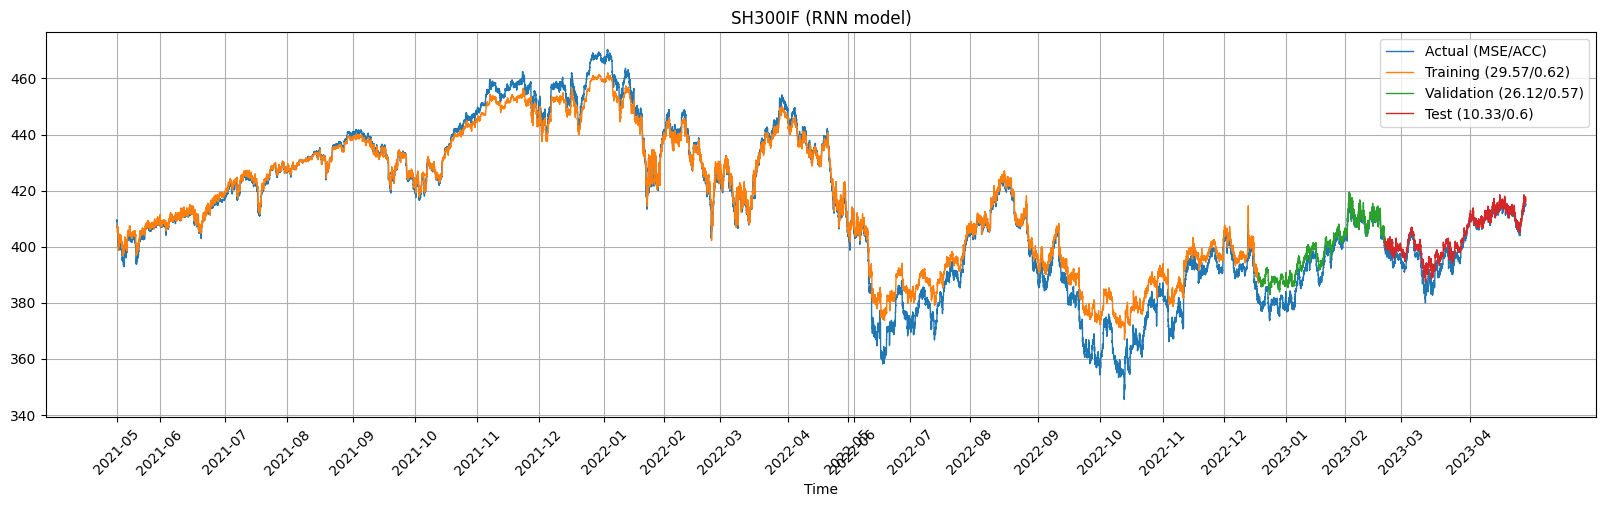

[0.9635884643921384, 1.0929941712721891, 0.6629570667164674]
[5.437496878517975, 5.111039008216461, 3.2135807567041264]


<ipython-input-53-85473a355a31>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_arr = np.array(RNN_predictions.predictions_org)
<ipython-input-53-85473a355a31>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  true_arr = np.array(RNN_predictions.true_org)


In [ ]:
# Plot the results on training, validation and test data sets for Simple RNN model
labels = ['Actual', 'Training', 'Validation', 'Test']
RNN_predictions.plot_predictions(title="SH300IF (RNN model)", labels=labels)
pred_arr = np.array(RNN_predictions.predictions_org)
true_arr = np.array(RNN_predictions.true_org)
#print(type(pred_arr))
#print(type(true_arr))
print(RNN_predictions.mape)
print(RNN_predictions.rmse)



In [ ]:
# Create a ModelPredictions object containing results from the GRU model 
GRU_predictions = ModelPredictions(GRU_model, 
                                   X = GRUdata.X, 
                                   y = GRUdata.y, 
                                   raw_y = GRUdata.raw_seq, 
                                   datetime = GRUdata.datetime,
                                   window = GRU_params['window'],
                                   batch_size = GRU_params['batch_size'])

142/142 [==============================] - 0s 3ms/step


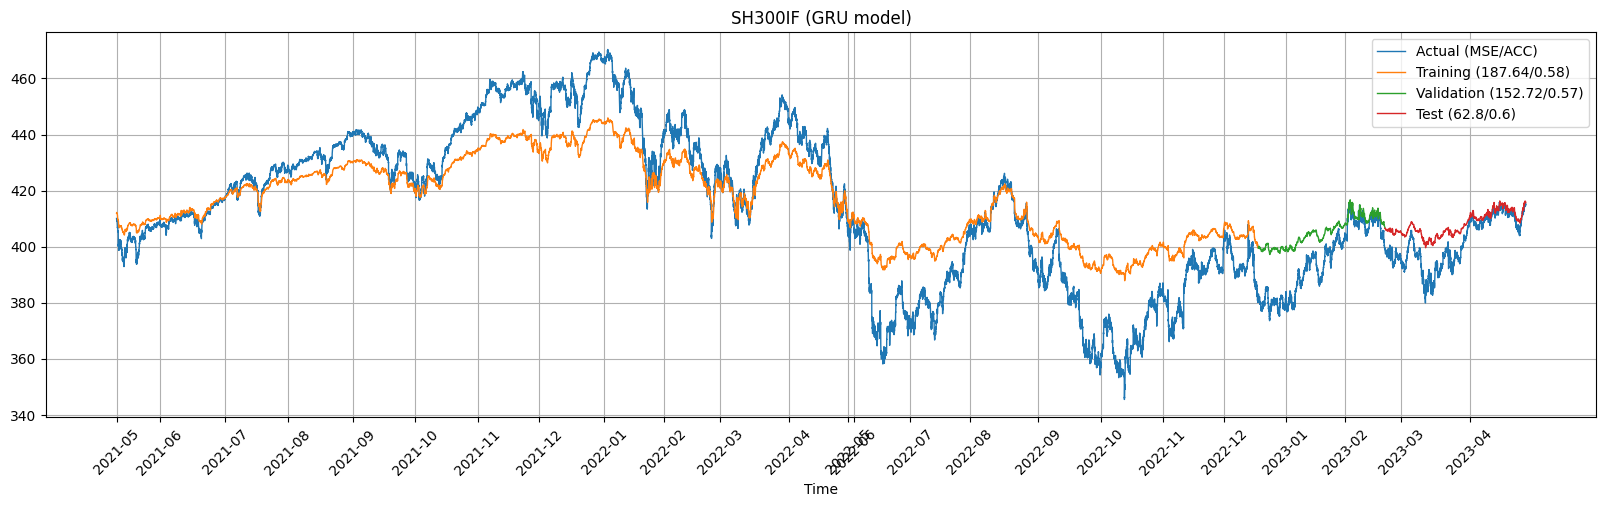

[2.6592713653693854, 2.628749744760956, 1.6082287499711794]
[13.69822065966229, 12.357892994973879, 7.924527921811174]


In [ ]:
# Plot the results on training, validation and test data sets for RNN-GRU model
labels = ['Actual', 'Training', 'Validation', 'Test']
GRU_predictions.plot_predictions(title="SH300IF (GRU model)", labels=labels)
print(GRU_predictions.mape)
print(GRU_predictions.rmse)

In [ ]:
# Create a ModelPredictions object containing results from the LSTM model 
LSTM_predictions = ModelPredictions(LSTM_model, 
                                    X = LSTMdata.X, 
                                    y = LSTMdata.y, 
                                    raw_y = LSTMdata.raw_seq, 
                                    datetime = LSTMdata.datetime,
                                    window = LSTM_params['window'],
                                    batch_size = LSTM_params['batch_size'])

142/142 [==============================] - 1s 6ms/step


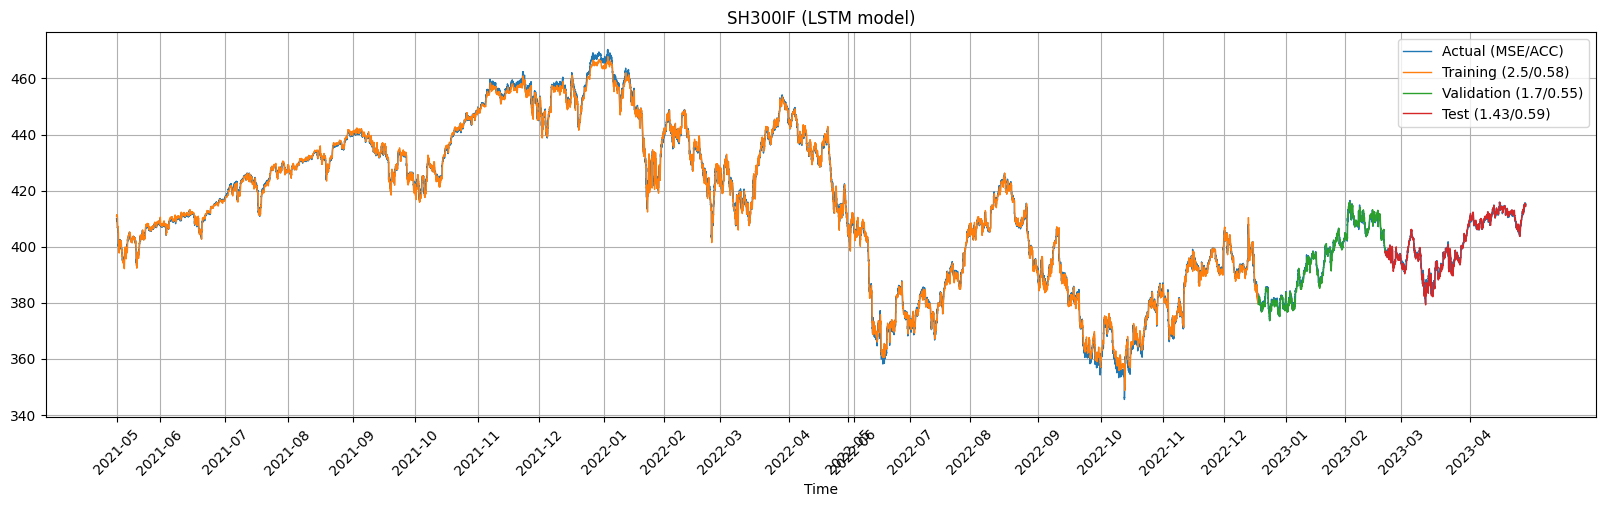

[0.27422469695263074, 0.24448209516339126, 0.21731530614053718]
[1.5813178891057553, 1.3019420934884727, 1.1968071821103385]


In [ ]:
# Plot the results on training, validation and test data sets for RNN-LSTM model
labels = ['Actual', 'Training', 'Validation', 'Test']
LSTM_predictions.plot_predictions(title="SH300IF (LSTM model)", labels=labels)
print(LSTM_predictions.mape)
print(LSTM_predictions.rmse)

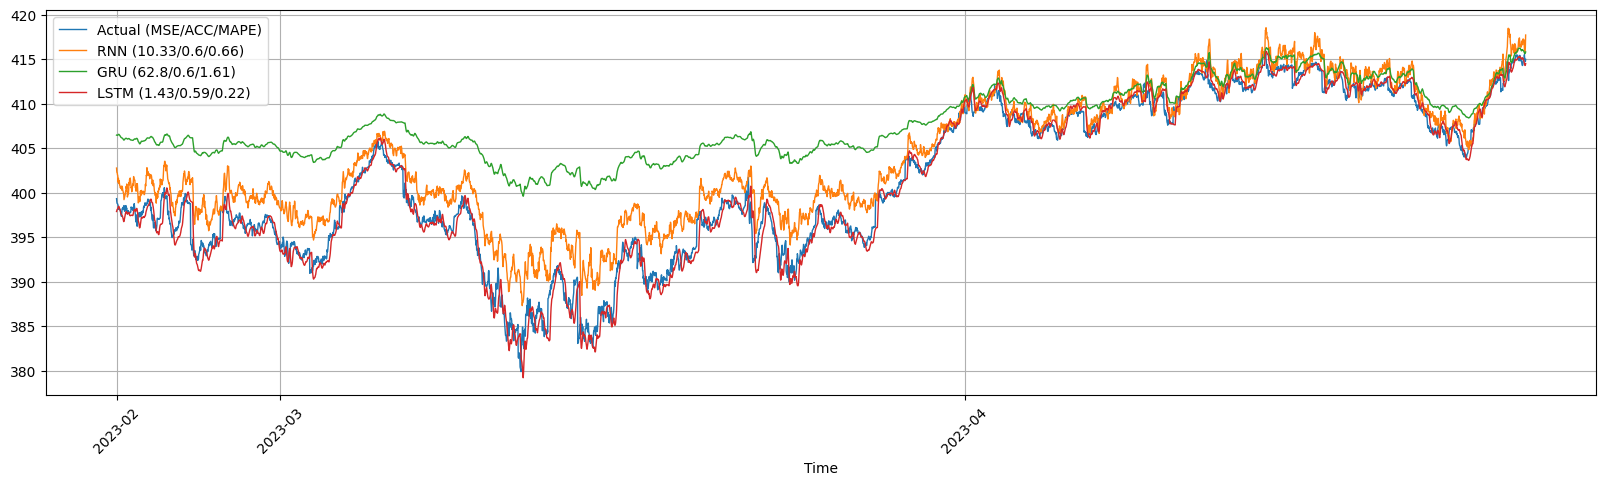

In [ ]:
# Plot and compare the results obtained from the three RNNs on the test data set
testset = [RNN_predictions.true_org[2], 
           RNN_predictions.predictions_org[2],
           GRU_predictions.predictions_org[2],
           LSTM_predictions.predictions_org[2]]
datetime = pd.Series(RNNdata.datetime[2].values, 
                     index = RNN_predictions.true_org[2].index)
labels = ['Actual', 'RNN', 'GRU', 'LSTM']
list_mse = [RNN_predictions.loss[2],
       GRU_predictions.loss[2],
       LSTM_predictions.loss[2]]
list_mda = [RNN_predictions.mda[2],
       GRU_predictions.mda[2],
       LSTM_predictions.mda[2]]
list_mape = [RNN_predictions.mape[2],
       GRU_predictions.mape[2],
       LSTM_predictions.mape[2]]
labels_loss = create_labels(labels, list_mse, list_mda,list_mape)
plot_seqs(testset, datetime=datetime, labels=labels_loss)

In [ ]:
# Load previously saved models, including architecture, weights and optimizer states
dependencies = {'rmse': rmse,
                'mda': mda}
saved_RNN = load_model(RNN_filepath, custom_objects=dependencies)

In [ ]:
# Create a StockIndexDataset object that contains new data for testing the SimpleRNN network
# Create the object with the key "test_only=True"

test_data = StockIndexDataset(datasets_path[-1], time_steps=RNN_params['time_steps'], 
                              forecast_steps=RNN_params['forecast_steps'],
                              batch_size=RNN_params['batch_size'], test_only=True)
test_data.info()

head2          date      time        open       close   volume  ema_5Candle  \
0  2021-05-10  11:25:00  409.563460  409.732596  1152187   409.453395   
1  2021-05-10  11:30:00  409.728423  409.700379   614125   409.469329   
2  2021-05-10  11:35:00  409.709016  409.678061   419928   409.482796   
3  2021-05-10  11:40:00  409.670201  409.544053   742130   409.486748   
4  2021-05-10  11:45:00  409.534349  409.671268   299483   409.498653   

   ema_20Candle        vwap  
0    409.319345  409.504211  
1    409.388624  409.641080  
2    409.441249  409.712025  
3    409.459941  409.651464  
4    409.498364  409.616761  
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Test Set Length: (45568, 1)


In [ ]:
# Create a ModelPredictions object containing results of the Simple RNN model on the test data set 
RNN_test = ModelPredictions(saved_RNN, 
                            X = test_data.X, 
                            y = test_data.y, 
                            raw_y = test_data.raw_seq, 
                            datetime = test_data.datetime,
                            window = RNN_params['window'],
                            batch_size = RNN_params['batch_size'])


1424/1424 [==============================] - 3s 2ms/step


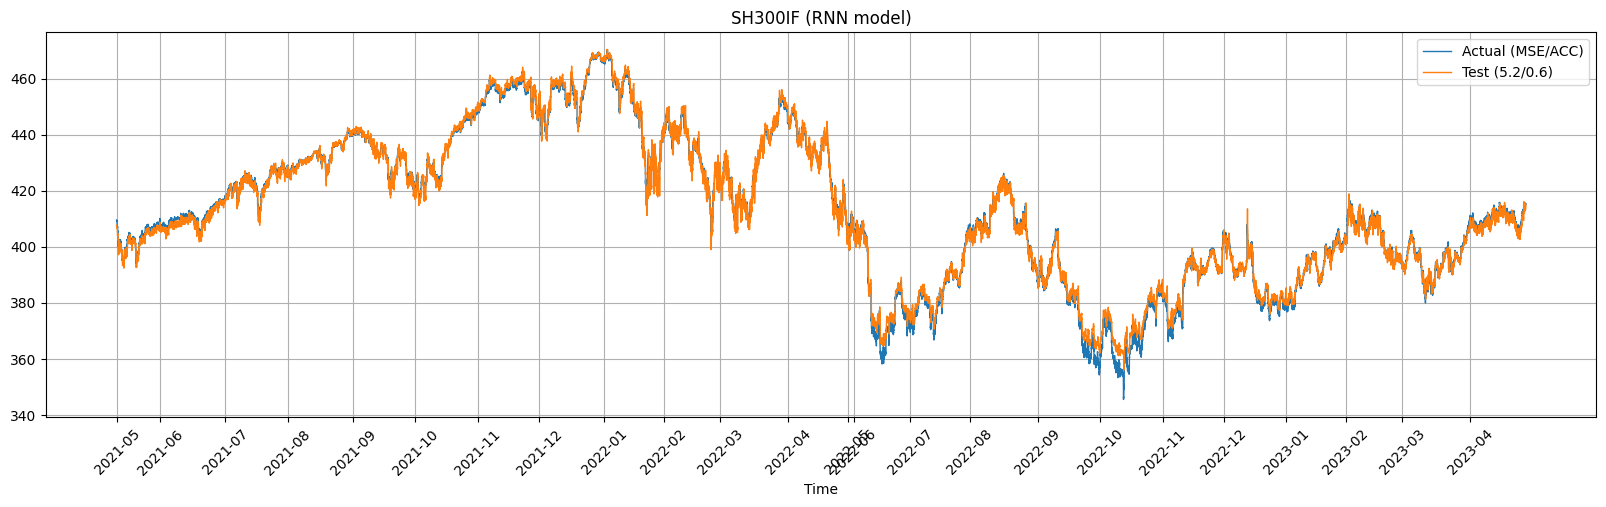

In [ ]:
# Plot the testing results
labels = ['Actual', 'Test']
RNN_test.plot_predictions(title="SH300IF (RNN model)", labels=labels)